In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import cmasher as cmr

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

In [2]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [3]:
mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gals2 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hals2 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2 = None; allsubs2 = None; states2 = None
keys2 = list(LG2.keys())
for key in keys2:
    sats = LG2[key]['sats']; subs = LG2[key]['subs']; real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats2 = sats if allsats2 is None else np.hstack((allsats2, sats))
    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
dinks2 = allsubs2[states2 == 'dink']
pairs2 = allsubs2[states2 == 'pair']
upairs2 = allsubs2[states2 == 'upair']

print(len(allsubs2), np.unique(states2, return_counts=True))

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [4]:
rtree1 = pklload(f"{database1}/reduced_tree.pickle")
rtree2 = pklload(f"{database2}/reduced_tree.pickle")

In [5]:
target = rtree1[1389][-1]

In [6]:
snap = snap1s.get_snap(target['timestep'])
snap.set_box_halo(target, 1, radius_name='r')
snap.get_cell(nthread=16)
cell = snap.cell

13.050007338820997
43860 36195 43728


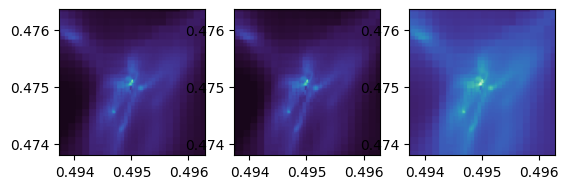

In [7]:
scale_nH = snap.unit_d / 1.66e-24 * 0.76

n_gmc = 10
del_star=2.e2
omega_b = 0.0455
rhoc = 1.8800000e-29
h0 = snap.H0
aexp = snap.aexp
XH = 0.76
mH = 1.6600000e-24
nCOM = del_star*omega_b*rhoc*(h0/100.)**2/aexp**3*XH/mH
d_gmc = max(nCOM, n_gmc) / scale_nH

print(d_gmc/snap.unit['H/cc'])
cold = cell[cell['T','K'] < 1e4]
deng = cell[cell['rho','H/cc'] < d_gmc/snap.unit['H/cc']]
print(len(cell), len(cold), len(deng))


fig, axes = plt.subplots(1,3)
painter.draw_gasmap(snap.cell, ax=axes[0])
painter.draw_gasmap(cold, ax=axes[1])
painter.draw_gasmap(deng, ax=axes[2])

# Parameters

In [8]:
smallr = 1e-10
gamma=1.6666667

In [9]:
# DENSITY: uold(ind_grid(i)+iskip,1)
# VELOCITY: xdp(i)=uold(ind_grid(i)+iskip,ivar)/max(uold(ind_grid(i)+iskip,1),smallr)
# PRESSURE: 
#   xdp(i)=uold(ind_grid(i)+iskip,ndim+2)
#   xdp(i)=xdp(i)-0.5d0*uold(ind_grid(i)+iskip,2)**2/max(uold(ind_grid(i)+iskip,1),smallr)
#   xdp(i)=xdp(i)-0.5d0*uold(ind_grid(i)+iskip,3)**2/max(uold(ind_grid(i)+iskip,1),smallr)
#   xdp(i)=xdp(i)-0.5d0*uold(ind_grid(i)+iskip,4)**2/max(uold(ind_grid(i)+iskip,1),smallr)
#   xdp(i)=(gamma-1d0)*xdp(i)
#
#   So, (p - [(vx**2) / 2d] - [(vy**2) / 2d]- [(vz**2) / 2d])*(gamma-1)
def cell2uold(cell, gamma=1.6666667, smallr=1e-10):
    uold1 = cell['rho']
    d = np.where(uold1>smallr, uold1, smallr)
    uold2 = cell['vx']*d
    uold3 = cell['vy']*d
    uold4 = cell['vz']*d
    uold5 = cell['P']/(gamma-1) + uold4**2/2/d + uold3**2/2/d + uold2**2/2/d
    uold = np.vstack((uold1, uold2, uold3, uold4, uold5)).T
    return uold

def uc(cell, key, gamma=1.6666667, smallr=1e-10):
    uold1 = cell['rho']
    if(key=='rho'):
        return uold1
    d = np.where(uold1>smallr, uold1, smallr)
    if(key[0]=='v'):
        return cell[key]*d
    uold2 = cell['vx']*d
    uold3 = cell['vy']*d
    uold4 = cell['vz']*d
    if(key=='P'):
        return cell[key]/(gamma-1) + uold4**2/2/d + uold3**2/2/d + uold2**2/2/d
    else:
        return None
uold = cell2uold(cell)

3.32106698059896e-09


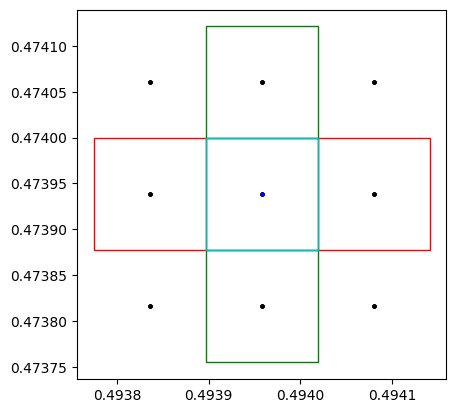

In [13]:
for icell in cell:
    dx = icell['dx']
    distx = np.abs(cell['x'] - icell['x'])
    disty = np.abs(cell['y'] - icell['y'])
    distz = np.abs(cell['z'] - icell['z'])
    indx = distx <= (dx/2 + cell['dx']/2)
    indy = disty <= (dx/2 + cell['dx']/2)
    indz = distz <= (dx/2 + cell['dx']/2)
    neighs = cell[indx&indy&indz]
    neighs = neighs[neighs['rho'] != icell['rho']]

    samez = (neighs['z'] <= (icell['z'] + icell['dx']/2))&(neighs['z'] >= (icell['z'] - icell['dx']/2))
    samey = (neighs['y'] <= (icell['y'] + icell['dx']/2))&(neighs['y'] >= (icell['y'] - icell['dx']/2))
    samex = (neighs['x'] <= (icell['x'] + icell['dx']/2))&(neighs['x'] >= (icell['x'] - icell['dx']/2))

    # left right
    sameyz = samey & samez
    lrs = neighs[sameyz]
    ls = lrs[lrs['x'] < icell['x']]
    if(len(ls) == 0): continue
    rs = lrs[lrs['x'] > icell['x']]
    if(len(rs) == 0): continue
    # front back
    samezx = samez & samex
    fbs = neighs[samezx]
    fs = fbs[fbs['y'] < icell['y']]
    if(len(fs) == 0): continue
    bs = fbs[fbs['y'] > icell['y']]
    if(len(bs) == 0): continue
    # up down
    samexy = samex & samey
    uds = neighs[samexy]
    us = uds[uds['z'] < icell['z']]
    if(len(us) == 0): continue
    ds = uds[uds['z'] > icell['z']]
    if(len(ds) == 0): continue
    break

trgv = 0
for val in ['vx','vy','vz']:
    vl = (np.average(uc(ls,val)*uc(ls, 'rho'), weights=ls['m']) + uc(icell,val)*uc(icell,'rho'))/(np.average(uc(ls,'rho'), weights=ls['vol']) + uc(icell,'rho'))
    vr = (np.average(uc(rs,val)*uc(rs, 'rho'), weights=rs['m']) + uc(icell,val)*uc(icell,'rho'))/(np.average(uc(rs,'rho'), weights=rs['vol']) + uc(icell,'rho'))
    vf = (np.average(uc(fs,val)*uc(fs, 'rho'), weights=fs['m']) + uc(icell,val)*uc(icell,'rho'))/(np.average(uc(fs,'rho'), weights=fs['vol']) + uc(icell,'rho'))
    vb = (np.average(uc(bs,val)*uc(bs, 'rho'), weights=bs['m']) + uc(icell,val)*uc(icell,'rho'))/(np.average(uc(bs,'rho'), weights=bs['vol']) + uc(icell,'rho'))
    vu = (np.average(uc(us,val)*uc(us, 'rho'), weights=us['m']) + uc(icell,val)*uc(icell,'rho'))/(np.average(uc(us,'rho'), weights=us['vol']) + uc(icell,'rho'))
    vd = (np.average(uc(ds,val)*uc(ds, 'rho'), weights=ds['m']) + uc(icell,val)*uc(icell,'rho'))/(np.average(uc(ds,'rho'), weights=ds['vol']) + uc(icell,'rho'))
    trgv += (vl-vr)**2 + (vf-vb)**2 + (vu-vd)**2
print(trgv)
    
gamma=1.6666667
smallc=1.e-10
omega_m = 0.272
c_s2 = max(smallc**2, uc(icell,'P')*(gamma - 1))
factG = 3/8/np.pi*omega_m*aexp

# star_formation.f90: 85
#   ! Mesh spacing in that level
ilevel = icell['level']
dx = 0.5**ilevel
boxlen = 1
scale    = boxlen
dx_loc   = dx*scale
alpha0 = 5/(np.pi*factG*uc(icell,'rho'))*(trgv + c_s2)/dx_loc**2
e_cts = 0.5
phi_t = 0.57 ; theta = 0.33
sigs  = np.log(1.0+0.16*trgv/c_s2)
scrit = np.log(0.067/theta**2*alpha0*trgv/c_s2)
sfr_ff(i) = e_cts/2.0*phi_t*exp(3.0/8.0*sigs)*(2.0-erfc((sigs-scrit)/sqrt(2.0*sigs)))

fig, ax = plt.subplots()
ax.scatter(neighs['x'], neighs['y'], s=5, c='k')
# for neigh in neighs:
    # if(neigh['level'] == icell['level']):
    # rectangle = plt.Rectangle((neigh['x']-neigh['dx']/2, neigh['y']-neigh['dx']/2), neigh['dx'], neigh['dx'], fill=False, color='k')
    # ax.add_patch(rectangle)   
for lr in lrs:
    rectangle = plt.Rectangle((lr['x']-lr['dx']/2, lr['y']-lr['dx']/2), lr['dx'], lr['dx'], fill=False, color='r')
    ax.add_patch(rectangle)   
for fb in fbs:
    rectangle = plt.Rectangle((fb['x']-fb['dx']/2, fb['y']-fb['dx']/2), fb['dx'], fb['dx'], fill=False, color='g')
    ax.add_patch(rectangle)   
for ud in uds:
    rectangle = plt.Rectangle((ud['x']-ud['dx']/2, ud['y']-ud['dx']/2), ud['dx'], ud['dx'], fill=False, color='c')
    ax.add_patch(rectangle)   
ax.scatter(icell['x'], icell['y'], s=5, c='b')
# rectangle = plt.Rectangle((icell['x']-dx/2, icell['y']-dx/2), dx, dx, fill=False, color='b')
# ax.add_patch(rectangle)
# rectangle = plt.Rectangle((icell['x']-dx, icell['y']-dx), dx*2, dx*2, fill=False, color='b')
# ax.add_patch(rectangle)
ax.set_aspect('equal')

In [ ]:
scale_nH = snap1.unit_d / 1.66e-24 * 0.76

n_gmc = 10
del_star=2.e2
omega_b = 0.0455
rhoc = 1.8800000e-29
h0 = snap1.H0
aexp = snap1.aexp
XH = 0.76
mH = 1.6600000e-24
nCOM = del_star*omega_b*rhoc*(h0/100.)**2/aexp**3*XH/mH
d_gmc = max(nCOM, n_gmc) / scale_nH

d_gmc/snap1.unit['H/cc']

13.050007338820997